DeepDreaming in its essence maximize the feature activations inside a neural network so as to amplify patterns in the input image.So instead of minimizing the loss as usual in the NN, it maximizes the feauture activations. This notebook uses a similar idea but takes two images as input: A content-image and a style-image. We then wish to create a mixed-image which has the contours of the content-image and the colours and texture of the style-image.
To do that I am going to slice off the top layer since its used for classification and then use the feature vectors at given layers to minimize the difference between two images.

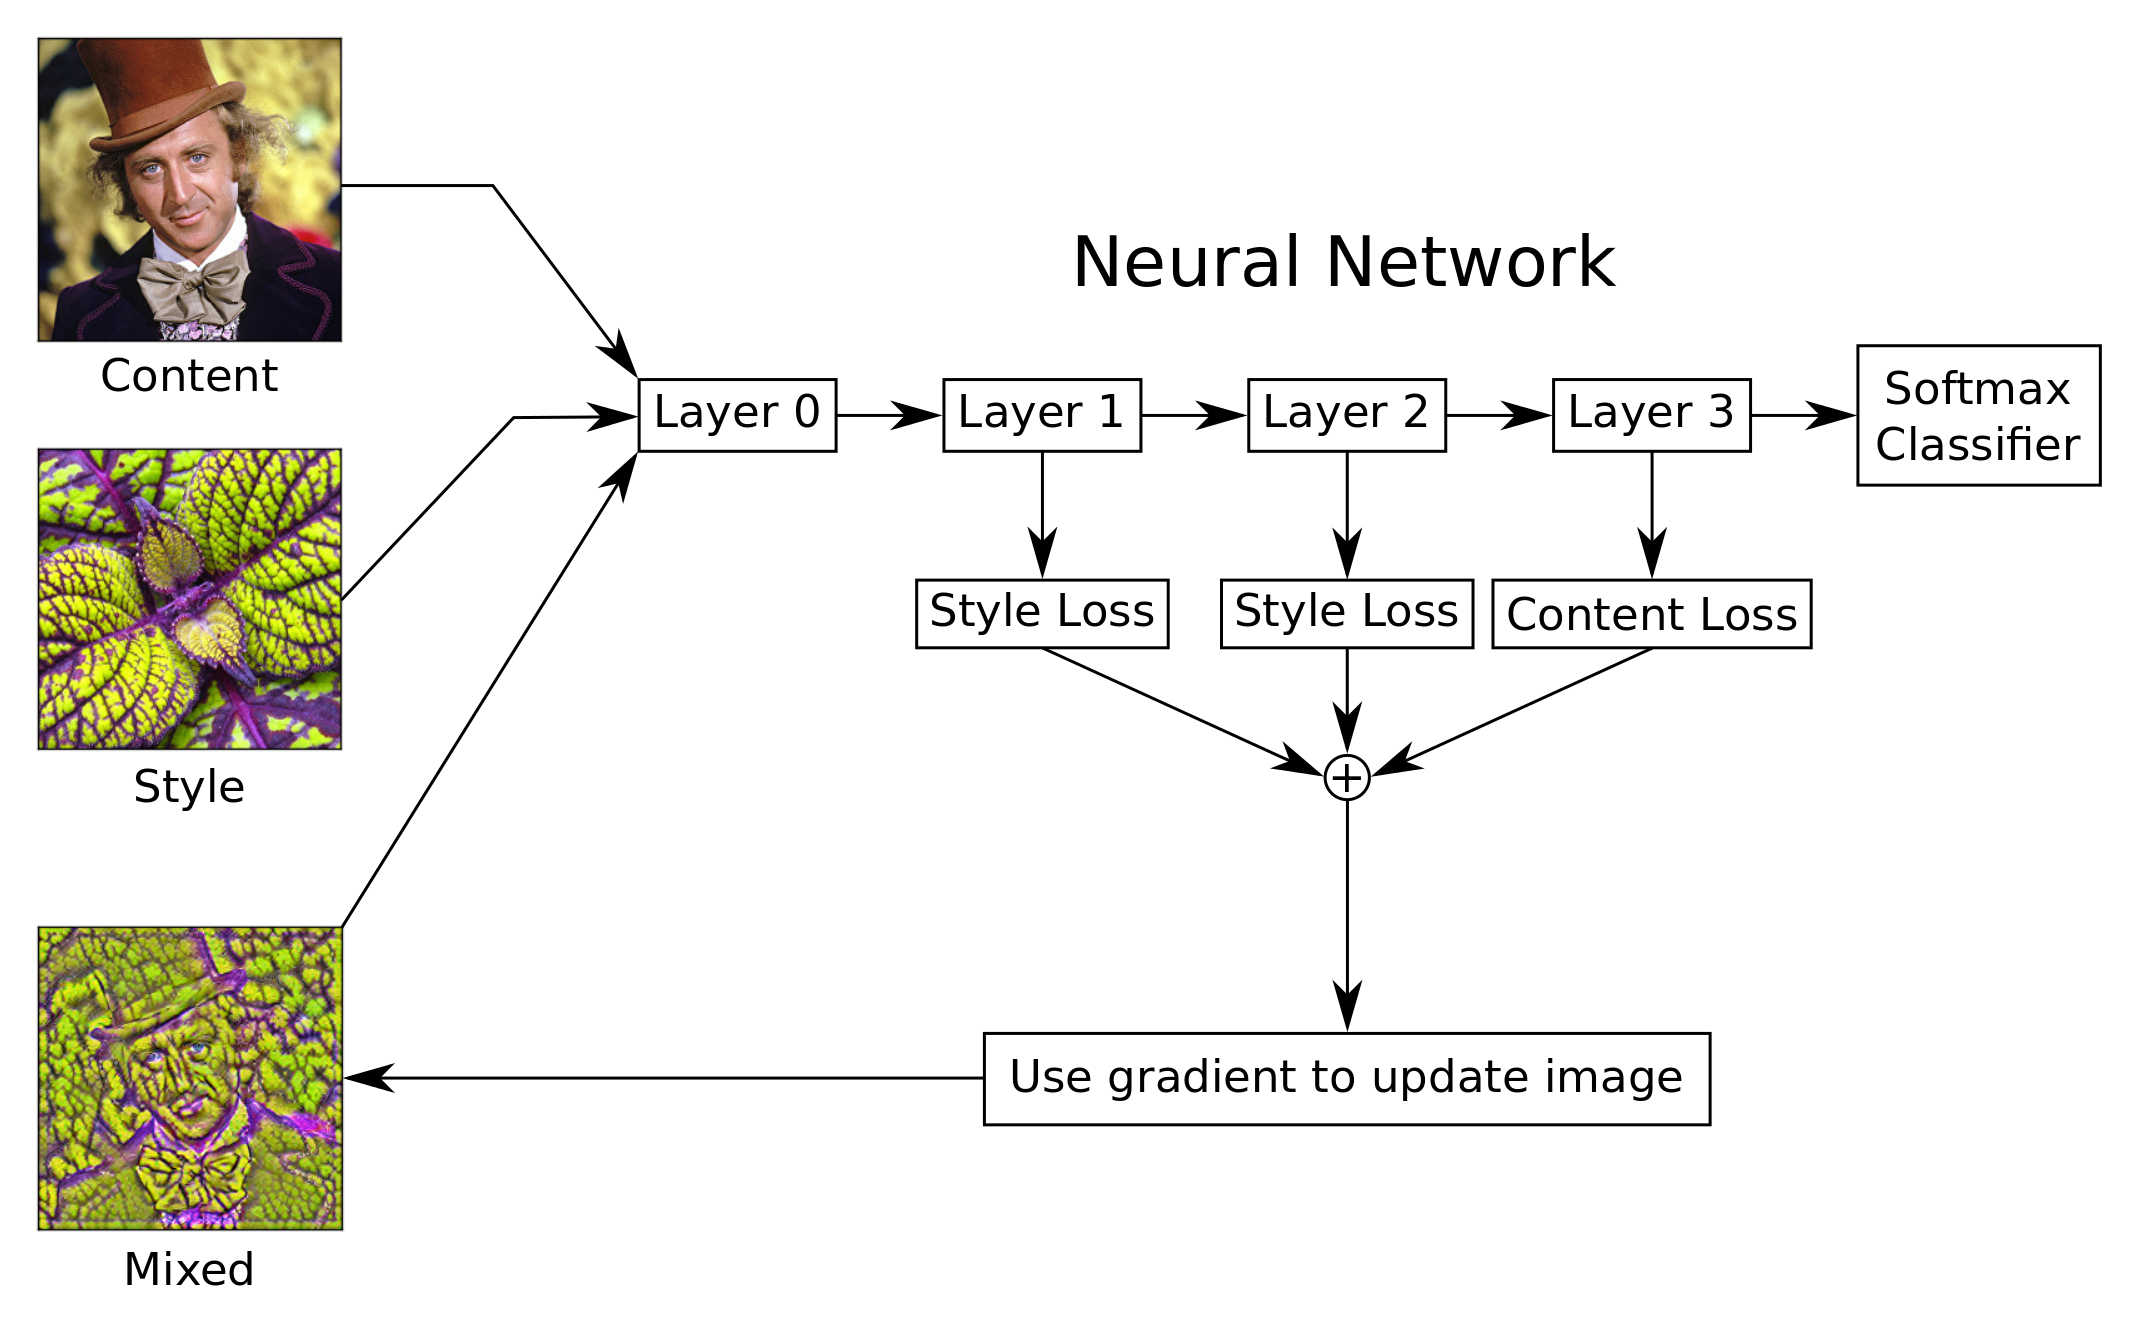

In [1]:
from IPython.display import Image, display
Image('images/style_transfer_flowchart.png')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

The original [paper](https://arxiv.org/abs/1508.06576) on style transfer used the VGG-19 convolutional neural network. But the pre-trained VGG-19 models for TensorFlow did not seem to be working properly for some reasons. Instead I will use the VGG-16 model, which someone else has made available and which can easily be loaded in TensorFlow. It is a pre-trained 16 layer convolution neural network. 

In [4]:
import vgg16

In [5]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## Helper-functions for image manipulation

In [6]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

In [7]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [8]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [9]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Loss Function

This function creates the loss-function for the content-image. It is the Mean Squared Error of the feature activations in the given layers in the model, between the content-image and the mixed-image. When this content-loss is minimized, it therefore means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers is selected, this should transfer the contours from the content-image to the mixed-image.

In [10]:
#loss function 
def mean_squared_error(a,b):
    return tf.reduce_mean(tf.square(a-b))

In [11]:
#content loss
def create_content_loss(session, model, content_image, layer_ids):
    #We feed in the dictionary what we want to work in the computation graph, in this case it is the content image
    feed_dict=model.create_feed_dict(image=content_image)
    
    #Define the layers
    layers=model.get_layer_tensors(layer_ids)
    
    #Values
    values=session.run(layers, feed_dict=feed_dict)
    
    #Run the model graph
    with model.graph.as_default():
        #intiliaze the losses
        layer_losses=[]
        
        for value, layer in zip(values, layers):
            value_const=tf.constant(value)
            
            loss=mean_squared_error(layer, value_const)
            
            layer_losses.append(loss)
            
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

For the style-layers we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

One way of doing this, is to calculate the so-called Gram-matrix for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

The [Gram matrix](https://i.stack.imgur.com/tU9ow.png) is used to measure the correlation between channels after flattening the filter images into vector. Gram matrix encodes second order statistics of the set of filters. It sort of mushes up all the features at a given layer, tossing spatial information in favor of a measure of how the different features are correlated. Gram matrix is transpose matrix with itself so each entry in gram matrix tells us if a feature channel has a tendency to be activated with another feature channel idea is to make the mixed image match patterns from style image. So basically, Gram matrices tosses away everything that is unnecessary just to focus on the style. 

In [12]:
def gram_matrix(tensor):  
    #4d tensor from convolutional layer
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    #-1 means whatever number makes the data fit 
    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels]) 
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

The next function creates the loss-function for the style-image. It is quite similar to create_content_loss() above, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.



In [13]:
def create_style_loss(session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict(image=style_image)
    layers = model.get_layer_tensors(layer_ids)
    
    with model.graph.as_default():
        gram_layers = [gram_matrix(layer) for layer in layers]
        values = session.run(gram_layers, feed_dict=feed_dict)
        layer_losses = []
        
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
    
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called Total Variation Denoising and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [14]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Style-Transfer Algorithm

Use gradient descent to find an image that minimizes the loss-functions of the content-layers and style-layers. This should result in a mixed-image that resembles the contours of the content-image, and resembles the colours and textures of the style-image.

In [15]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    
    model = vgg16.VGG16()
    
    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)
    
    
    # Create TensorFlow variables for adjusting the values of the loss-functions
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
    
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])
    
    # Updating the adjustment values with a small value 
    # 1e-10 added to avoid the possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise
            
    gradient = tf.gradients(loss_combined, model.input)
    
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]
    
    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    # where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image=mixed_image)
        
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        # Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image


# ---------------------------------------------------------------------------------------------------------------
## Test

Load the content-image which has the overall contours that we want in the mixed-image.

In [16]:
content_filename = 'elon_musk.jpg'
content_image = load_image(content_filename, max_size=None)

Load the style-image which has the colours and textures we want in the mixed-image.

In [17]:
style_filename = 'style.jpg'
style_image = load_image(style_filename, max_size=300)

In [18]:
content_layer_ids = [4]

List of integers for the style-layers.

In [19]:
style_layer_ids = list(range(13))

## Result

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 6.94e-11, Style: 3.34e-29, Denoise: 5.59e-06


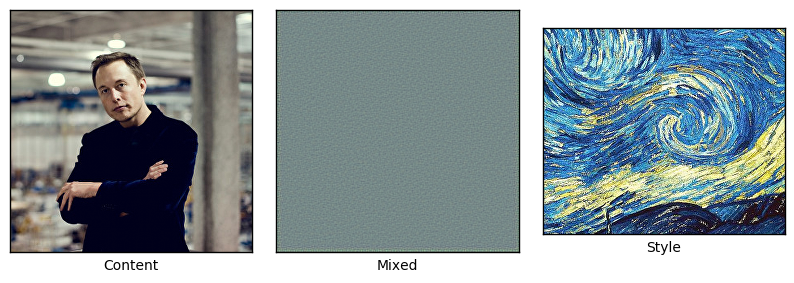

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 4.07e-11, Style: 8.13e-28, Denoise: 8.68e-08


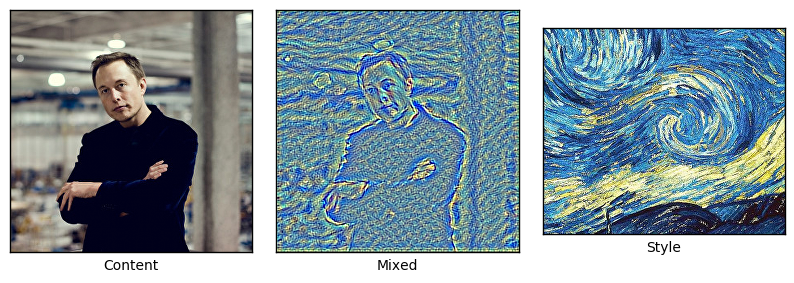

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 4.03e-11, Style: 9.55e-28, Denoise: 8.53e-08


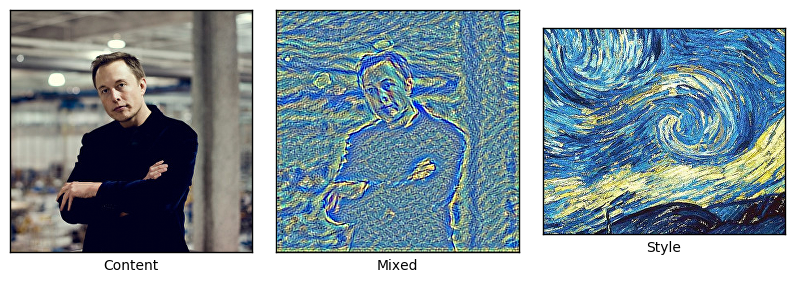

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 4.00e-11, Style: 1.09e-27, Denoise: 8.35e-08


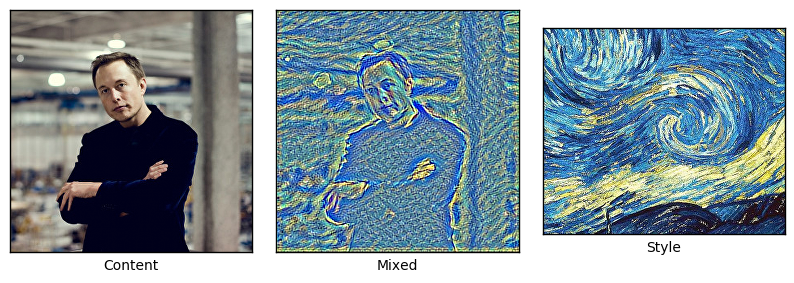

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 3.99e-11, Style: 1.23e-27, Denoise: 8.16e-08


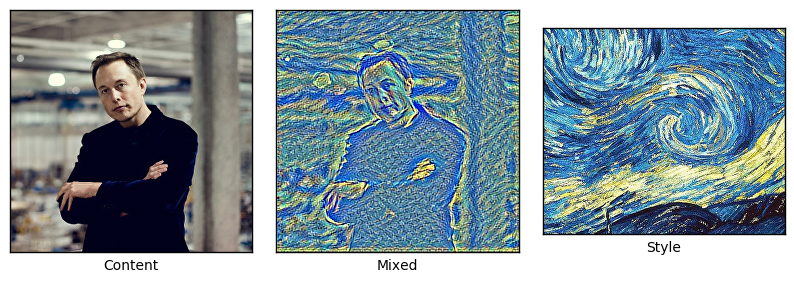

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 3.96e-11, Style: 1.40e-27, Denoise: 7.98e-08


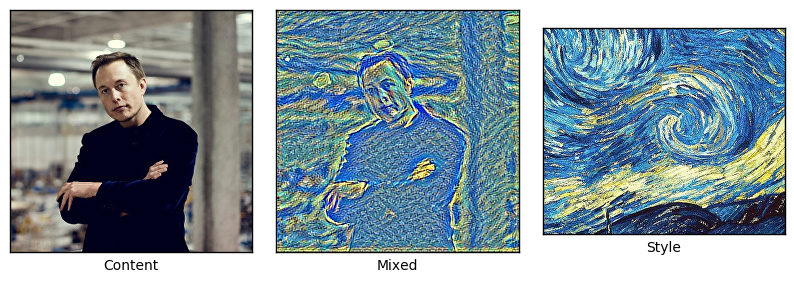

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 2.73e-11, Style: 4.44e-28, Denoise: 5.97e-08


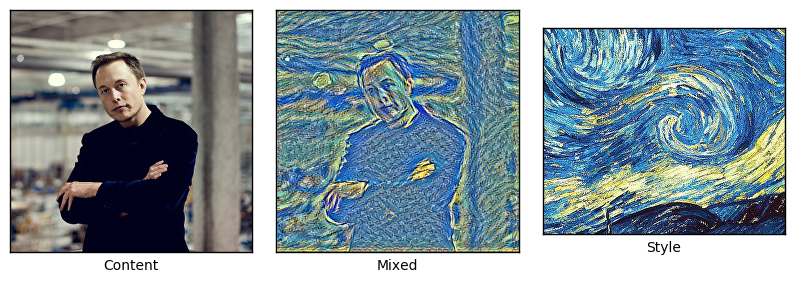


Final image:


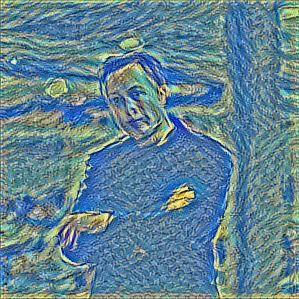

Wall time: 6min 31s


In [20]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)